<a href="https://colab.research.google.com/github/gebakkenAardappel/WINC/blob/main/CO2_emissions_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext google.colab.data_table

# Data keuze:
Meerdere datasets zijn bekeken in relatie tot CO2 uitstoot, namelijk data over vleesconsumptie, sectortype (industrie/mobiliteit) en gebruikte energiebronnen. Ook is gekeken naar de prijsontwikkeling van de niet-fossiele energiebronnen als toekomstige vervanging van fossiele energie.


In [38]:
# CO2 uitstoot per persoon
CO2=pd.read_csv("https://raw.githubusercontent.com/gebakkenAardappel/WINC/main/co-emissions-per-capita.csv")

# verschillende energiebronnen, incl. de uitstoot per persoon. Hier moeten de juiste kolommen - per persoon- nog uitgehaald worden:
df=pd.read_csv("https://raw.githubusercontent.com/gebakkenAardappel/WINC/main/owid-co2-data.csv")
df1=df.loc[: , ['country', 'year', 'iso_code','co2_per_capita','cement_co2_per_capita', 
                'coal_co2_per_capita', 'consumption_co2_per_capita','flaring_co2_per_capita','gas_co2_per_capita', 
                'land_use_change_co2_per_capita', 'oil_co2_per_capita']]

# sector data per persoon (o.a. type mobiliteit/aantal gebouwen/industrialisatie)
df_2=pd.read_csv("https://raw.githubusercontent.com/gebakkenAardappel/WINC/main/per-capita-co2-sector.csv")
df2=df_2.drop(columns=['Fugitive emissions (per capita)', 'Land-use change and forestry (per capita)'])

# vleesgebruik per vleessoort in kg/jaar per persoon: 
df_3=pd.read_csv("https://raw.githubusercontent.com/gebakkenAardappel/WINC/main/per-capita-meat-type.csv")
df3=df_3.rename(columns={'Meat, poultry | 00002734 || Food available for consumption | 0645pc || kilograms per year per capita': 'pluimvee',
       'Meat, beef | 00002731 || Food available for consumption | 0645pc || kilograms per year per capita': "rund",
       'Meat, sheep and goat | 00002732 || Food available for consumption | 0645pc || kilograms per year per capita':"schaap en geit",
       'Meat, pig | 00002733 || Food available for consumption | 0645pc || kilograms per year per capita': "varken",
       'Meat, Other | 00002735 || Food available for consumption | 0645pc || kilograms per year per capita': "anders",
       'Fish and seafood | 00002960 || Food available for consumption | 0645pc || kilograms per year per capita': "vis en zeefruit"})

# Vraag 1.Wat is de beste voorspeller voor een hoge CO2-uitstoot per persoon ?
gekeken is naar
*   vleesconsumptie (type vlees)
*   aanwezigheid van verschillende (transport)sectoren
*   gebruikte energiebronnen



# vleesconsumptie

In [39]:
Vleesconsumptie=pd.merge(CO2,df3, on=["Year","Code","Entity"]).dropna()   
Vleesconsumptie.drop(columns=["Code"],inplace=True)
# Kuwait en Namibia uit de grafiek voor de relatie met vleesconsumptie verwijderd.
# Kuwait wijkt enorm af. Dit kan t.g.v. bijv. grote olieproduktie zijn. Namibia heeft 0 emissie.
vleesconsumptie =Vleesconsumptie.loc[(Vleesconsumptie.Entity != "Kuwait") & (Vleesconsumptie.Entity != "Namibia")]
#vleesconsumptie

In [51]:
# correlatie bepalen voor de kolommen die niet in de volgende lijst zitten
Niet_correleren=["Year", "Entity","Annual CO₂ emissions (per capita)"]

def correlatie(dataframe,titel):
  x_waarde=[]  # voor alle kolomnamen
  y_waarde=[]  # voor alle correlatie waardes 
  for kolomnaam in dataframe.columns:
    if kolomnaam not in Niet_correleren:
      npArr1=np.array(dataframe['Annual CO₂ emissions (per capita)'])
      npArr2=np.array( dataframe[f"{kolomnaam}"])
      correl=np.corrcoef(npArr1,npArr2)
      x_waarde.append(f"{kolomnaam}")
      y_waarde.append(correl[0,1]) 
      print (f'Correlatie Jaarlijkse CO2 uitstoot - Consumptie van {kolomnaam} = {correl[0,1]}')  
  plt.title(titel,fontsize=14) 
  plt.ylabel("correlatie met CO2 uitstoot", fontsize=14) 
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.grid()
  plt.xticks(rotation=90)  
  plt.scatter(x_waarde,y_waarde)

Relatie CO2 en vleesconsumptie.
Er is er van uit gegaan dat 0.0 ook betekent dat een bepaald type vlees in dat land niet gegeten wordt.

Correlatie Jaarlijkse CO2 uitstoot - Consumptie van pluimvee = 0.43524987932606735
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van rund = 0.43258453076906445
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van schaap en geit = 0.1421051121879401
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van varken = 0.5006877808444196
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van anders = 0.022851089880597752
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van vis en zeefruit = 0.19709256253440785


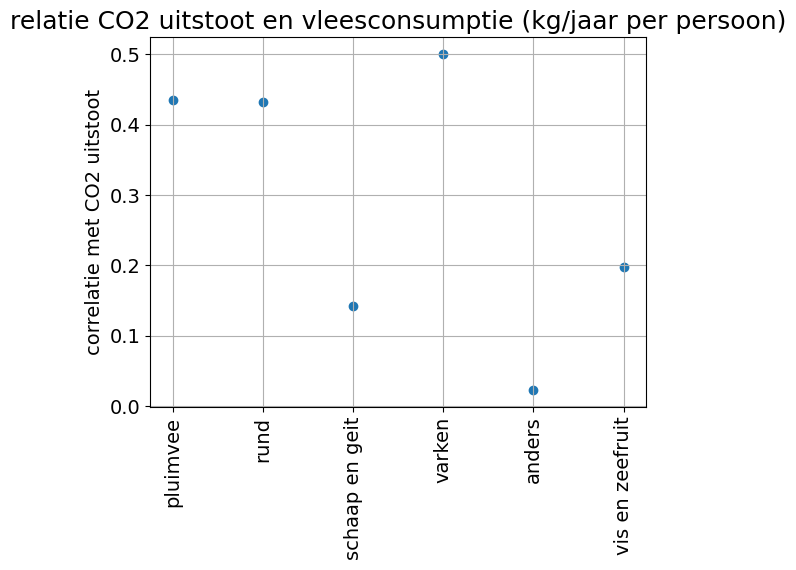

In [50]:
correlatie(vleesconsumptie,"relatie CO2 uitstoot en vleesconsumptie (kg/jaar per persoon)")

Conclusie: de consumptie van varkensvlees is het meest belastend voor de CO2 uitstoot, schapen- en geitenvlees zijn het minst belastend.

# sector

In [30]:
# alleen data per persoon gebruikt
sect=df2.rename(columns={ 'Annual CO₂ emissions (per capita)' : "jaarlijkse CO2 uitstoot",
                       'Buildings (per capita)':"gebouwen",
                       'Electricity and heat (per capita)':"electriciteit en verwarming",
                       'Industry (per capita)': "industrie",  
                       'Aviation and shipping (per capita)': "vliegen en scheepvaart",
                       'Transport (per capita)':"transport",
                       'Manufacturing and construction (per capita)':"fabricage en constructie"})
sector=pd.merge(CO2,sect, on=["Year","Code","Entity"]).dropna()   
sector.drop(columns=["Code"],inplace=True)
#sector.head(1)

Relatie CO2 en sectortype

Correlatie Jaarlijkse CO2 uitstoot - Consumptie van gebouwen = 0.35061213705853833
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van electriciteit en verwarming = 0.7165068414609319
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van industrie = 0.47593924080044786
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van vliegen en scheepvaart = 0.22816616513666288
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van transport = 0.5758366898963124
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van fabricage en constructie = 0.5955608530880679


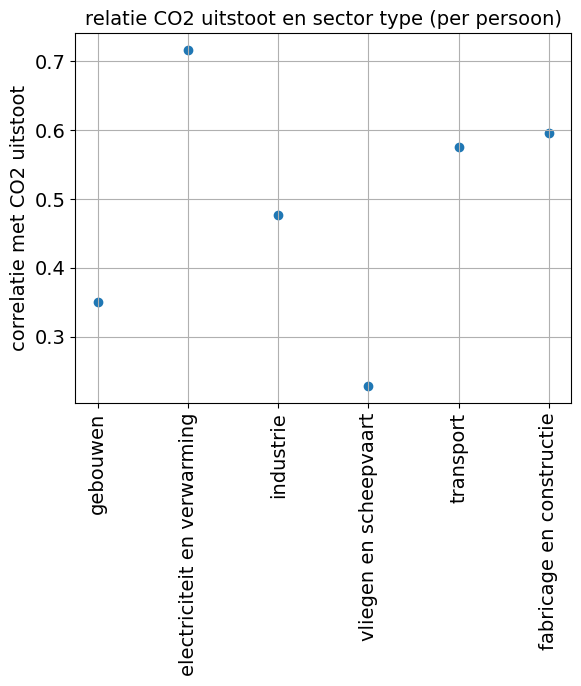

In [52]:
correlatie(sector, "relatie CO2 uitstoot en sector type (per persoon)")

Conclusie: vliegen en scheepsvaart dragen per persoon het minst bij aan de CO2 uitstoot. Hoeveel per persoon echter gevlogen/gevaren wordt t.o.v. gebruik van andere transportmiddelen is niet bekend. Per persoon wordt de meeste CO2 uitstoot het gevolg van gebruik van electriciteit/verwarming.

# energiebronnen


In [28]:
# alle gekozen data zijn per persoon 
energiebronnen=df1.rename(columns={'country': "Entity", 'year':"Year", 
                                   'cement_co2_per_capita':"cement",               
                                   'coal_co2_per_capita':"kolen", 'consumption_co2_per_capita':"consumptie",
                                   'flaring_co2_per_capita':"verbranding", 
                                   'gas_co2_per_capita':"gas",'land_use_change_co2_per_capita':"veranderd landgebruik", 
                                   'oil_co2_per_capita':"olie"})
energiebron=pd.merge(CO2,energiebronnen, on=["Entity","Year"]).dropna()  
energiebron.drop(columns=["Code", "iso_code","co2_per_capita"],inplace=True)
#energiebron.head(1)


Relatie CO2 uitstoot en energiebronnen

Correlatie Jaarlijkse CO2 uitstoot - Consumptie van cement = 0.4443254032626242
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van kolen = 0.2808157332104453
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van consumptie = 0.6977844302977296
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van verbranding = 0.6740447649867177
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van gas = 0.6576362594686466
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van veranderd landgebruik = -0.14488501423525005
Correlatie Jaarlijkse CO2 uitstoot - Consumptie van olie = 0.831595271006656


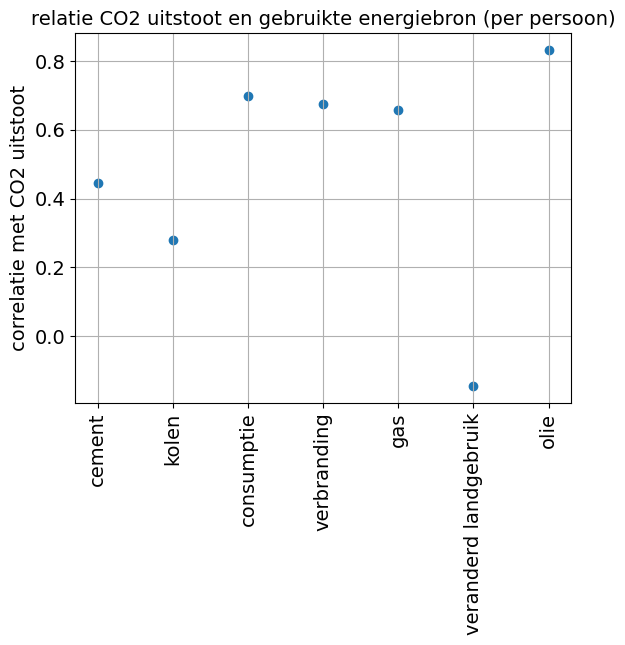

In [53]:
correlatie(energiebron,"relatie CO2 uitstoot en gebruikte energiebron (per persoon)")  # misschien mooier om hier een andere database voor te pakken: CO2 emissions by fuel line(zie github) of betere kolomselectie maken

Conclusie: Olie is de meest vervuilende energiebron m.b.t. CO2 uitstoot, veranderd landgebruik verlaagd de CO2 uitstoot zelfs. 

# 2.  welke landen verlagen hun CO2 output het meest?   
Per land en per persoon bekijken vanaf 2016 (start klimaatdoelen) en vergelijken met de laatst bekende meting (2021): 

2016: Ondertekening Klimaatakkoord van Parijs door Europese Unie. 
Doel: opwarming aarde beperken tot ruim onder 2 graden Celsius. 
ref.: https://www.rijksoverheid.nl/onderwerpen/klimaatverandering/klimaatbeleid



In [11]:
# CO2 per persoon en per land berekenen vanaf 2016 (start klimaatdoelen)
reductie=df.loc[df["year"]>=2016,['country', 'year','co2','co2_per_capita']].dropna()

# referentie is de uitstoot in 2016 genomen per land en per-land-per-persoon.
reductie["ref2016"] =reductie.loc[reductie["year"]==2016,["co2"]]  
reductie["ref2016_pp"]=reductie.loc[reductie["year"]==2016,["co2_per_capita"]]

# Referentiewaarden voor elk land toevoegen als nieuwe kolom: 
#    referentietabel maken vd uitstoot in 2016 en NaN verwijderen. 
referentielijst2016=reductie.loc[:,["country","ref2016","ref2016_pp"]].dropna()
#    opgeschoonde lijst waardes koppelen aan de juiste landen  (zonder .dropna(): "reductie.ref2016" bevat NaN voor jaartallen != 2016)
relatief=pd.merge(reductie,referentielijst2016, on=["country"]) 
#    oude referentiekolommen, waarin NaN waardes, verwijderen          
relatief.drop(columns=["ref2016_pp_x", "ref2016_x"],inplace=True)

# relatieve vermindering t.o.v. 2016 bepalen: hoger getal = meer reductie
relatief["relVerlaging.PerPersoon"]=(relatief["ref2016_pp_y"]-relatief["co2_per_capita"]) / relatief["ref2016_pp_y"]
relatief["relVerlaging.Land"]=(relatief["ref2016_y"]-relatief["co2"]) / relatief["ref2016_y"]

# onzinnige waardes vervangen door nan
relatief["co2"].replace(0.0,np.nan,inplace=True)
relatief["co2_per_capita"].replace(0.0,np.nan,inplace=True)  
relatief["ref2016_y"].replace(0.0,np.nan,inplace=True)
relatief["ref2016_pp_y"].replace(0.0,np.nan,inplace=True)
# niet-landen vervangen door nan: 
relatief["country"].replace("World",np.nan,inplace=True)
# nan-waardes verwijderen
relatief.dropna(subset=["co2", "co2_per_capita","ref2016_y","ref2016_pp_y","country"],inplace=True)

# Laatst bekende meting (2021) gekozen om te bepalen wie de grootste reductie gerealiseerd heeft tov 2016:
data2021=relatief.loc[relatief["year"]==2021]

Beste reductie per landen in CO2 verlaging per hoofd vd bevolking

In [12]:
# staafdiagram om straks de data in weer te geven
def plot_values(df,x,y,titel,y_label):

  plt.ylabel(y_label)
  plt.title(f"{titel}")
  plt.figsize = (3,3)
  df[y].head(5).plot(kind="bar")

In [13]:
PerPersoon=data2021.sort_values(by="relVerlaging.PerPersoon", ascending=False).set_index("country")
PerPersoon.head(5)

,year,co2,co2_per_capita,ref2016_y,ref2016_pp_y,relVerlaging.PerPersoon,relVerlaging.Land
country,,,,,,,
Curacao,2021,1.844,9.686,5.800,33.968,0.714849,0.682069
Venezuela,2021,79.747,2.828,152.385,4.957,0.429494,0.476674
Estonia,2021,10.449,7.864,17.559,13.344,0.410671,0.404921
Equatorial Guinea,2021,5.225,3.197,7.560,5.404,0.408401,0.308862
Macao,2021,1.287,1.874,1.781,2.841,0.340373,0.277372


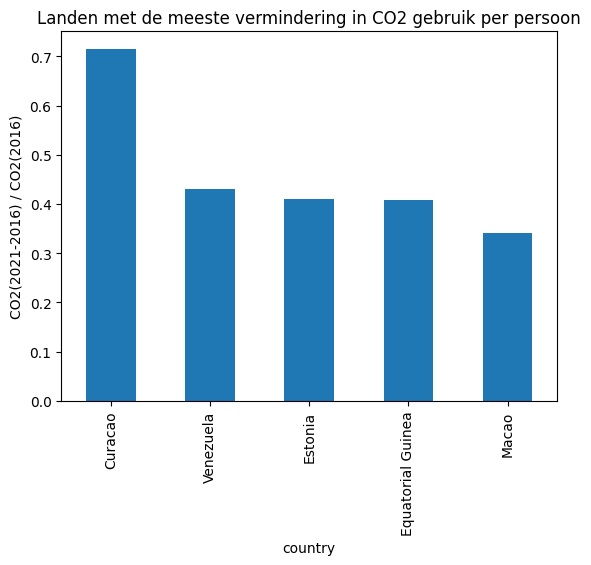

In [14]:
plot_values(PerPersoon,"country","relVerlaging.PerPersoon", "Landen met de meeste vermindering in CO2 gebruik per persoon", "CO2(2021-2016) / CO2(2016)")

Beste reductie per land als geheel

In [15]:
PerLand=data2021.sort_values(by="relVerlaging.Land", ascending=False).set_index("country")
PerLand.head(5)

,year,co2,co2_per_capita,ref2016_y,ref2016_pp_y,relVerlaging.PerPersoon,relVerlaging.Land
country,,,,,,,
Curacao,2021,1.844,9.686,5.800,33.968,0.714849,0.682069
Venezuela,2021,79.747,2.828,152.385,4.957,0.429494,0.476674
Estonia,2021,10.449,7.864,17.559,13.344,0.410671,0.404921
Bosnia and Herzegovina,2021,13.566,4.148,21.730,6.243,0.335576,0.375702
Kosovo,2021,5.644,3.396,8.856,5.058,0.328588,0.362692


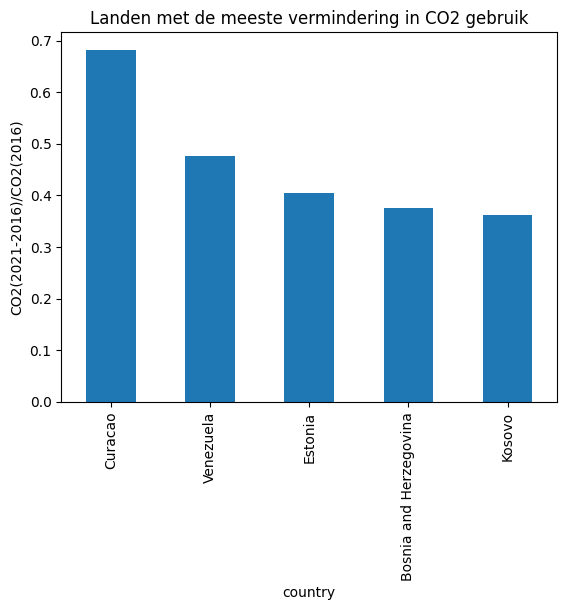

In [16]:
plot_values(PerLand,"country","relVerlaging.Land", "Landen met de meeste vermindering in CO2 gebruik", "CO2(2021-2016)/CO2(2016)")

Conclusie: zowel landelijk gezien als per persoon heeft Curacao de beste reductie in CO2 t.o.v. 2016, gemeten in 2021

# 3: Beste toekomstige prijs voor niet-fossiele energie
welke niet fossiele energie technologie zal de beste prijs in de toekomst hebben?
Om dit te kunnen voorspellen zul je waarschijnlijk lineaire regressie over de verschillende niet-fossiele opties moeten gebruiken.

In [17]:
# bekijk het prijsverloop wereldwijd en pak de data vanaf 2010 ->
EC=pd.read_csv("https://raw.githubusercontent.com/gebakkenAardappel/WINC/main/levelized-cost-of-energy.csv")
EC_Wereldwijd=EC.loc[(EC["Entity"]=="World")&(EC["Year"]>=2010)].drop(columns=["Entity","Code",'Concentrated solar power levelized cost of energy'])
Energiekosten_Wereldwijd=EC_Wereldwijd.rename(columns={'Year':"Jaar", 'Bioenergy levelized cost of energy': "Bioenergie",
       'Geothermal levelized cost of energy': "Aardwarmte",
       'Offshore wind levelized cost of energy':"Aflandse windenergie",
       'Solar photovoltaic levelized cost of energy':"Zonne-energie",
       'Hydropower levelized cost of energy': "Waterkracht",
       'Onshore wind levelized cost of energy':"Inlandse windenergie "},)
Energiekosten_Wereldwijd

,Jaar,Bioenergie,Aardwarmte,Aflandse windenergie,Zonne-energie,Waterkracht,Inlandse windenergie
447,2010,0.078189,0.050445,0.187857,0.417149,0.038883,0.102061
448,2011,0.056684,NaN,0.197549,0.311298,0.036561,0.096487
449,2012,0.061879,0.085695,0.166601,0.232633,0.038038,0.088390
450,2013,0.082198,0.064111,0.166662,0.179401,0.042512,0.089206
451,2014,0.082375,0.065335,0.172199,0.161258,0.042457,0.080203
452,2015,0.072771,0.058849,0.140527,0.121080,0.036572,0.068962
453,2016,0.071178,0.067802,0.116323,0.106340,0.048389,0.063855
454,2017,0.071070,0.070917,0.106152,0.083660,0.050722,0.059959
455,2018,0.055360,0.067583,0.100049,0.071139,0.039837,0.050880
456,2019,0.063933,0.067305,0.086388,0.062119,0.041409,0.044592


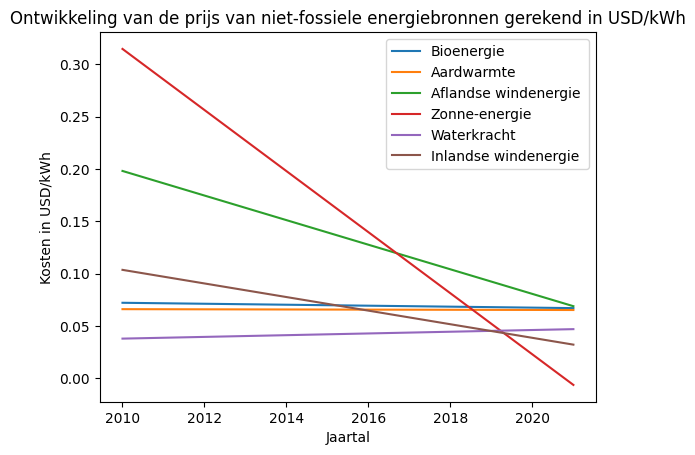

In [18]:
# regressielijnen berekenen per kolom
Jaar = Energiekosten_Wereldwijd[["Jaar"]]

for kolomnaam in Energiekosten_Wereldwijd.columns:
  niet_bepalen=["index","Jaar"]

  if kolomnaam not in niet_bepalen:
    Kosten = Energiekosten_Wereldwijd[[kolomnaam]].interpolate(method="linear")
    # lineaire regressie over (x,y) = (jaar,kosten)
    regressor = LinearRegression()
    regressor.fit(Jaar, Kosten)
    Kosten_pred = regressor.predict(Jaar)
    plt.plot(Jaar, regressor.predict(Jaar), label=f"{kolomnaam}")
  plt.title("Ontwikkeling van de prijs van niet-fossiele energiebronnen gerekend in USD/kWh")
  plt.xlabel("Jaartal")
  plt.ylabel("Kosten in USD/kWh")
  plt.legend()

Conclusie m.b.t.de kosten van niet fossiele energiebronnen:
Zonne-energie wordt op termijn de goedkoopste energie.